#Preparing the data
* Importing libraries
* Getting mutations profile


In [54]:
#import libraries

import scipy.io as sio
import numpy as np
import math
import pandas as pd
from google.colab import files
import csv
import random
import matplotlib.pyplot as plt
from statsmodels.stats.multitest import multipletests
from scipy.stats import mannwhitneyu
import seaborn as sns
import matplotlib.patches as patches
import matplotlib.patches as patches
import matplotlib.colors as mcolors

In [55]:
#read the profiles
control_path = '/content/drive/MyDrive/RT_signatures/mutagen_indels_control_all.ID28.all'
exp_path = '/content/drive/MyDrive/RT_signatures/mutagen_indels_exp_all.ID28.all'

control = pd.read_csv(control_path, sep='\t')
exp = pd.read_csv(exp_path, sep='\t')
print(control.head(), exp.head()) #$

  MutationType  MSM0.118_s1  MSM0.118_s2  MSM0.119_s1  MSM0.119_s2  \
0    1:Del:C:0            1            0            0            0   
1    1:Del:C:1            0            0            1            0   
2    1:Del:C:2            1            0            0            0   
3    1:Del:C:3            0            1            0            0   
4    1:Del:C:4            0            0            0            0   

   MSM0.120_s1  MSM0.120_s2  MSM0.120_s3  MSM0.127_s1  MSM0.127_s2  ...  \
0            0            3            1            1            0  ...   
1            0            0            0            0            0  ...   
2            0            0            0            0            0  ...   
3            0            0            0            0            0  ...   
4            0            0            0            0            0  ...   

   MSM0.4_s2  MSM0.6_s1  MSM0.6_s2  MSM0.86_s1  MSM0.86_s2  MSM0.8_s1  \
0          0          0          0           0         

In [56]:
exp.drop(columns=['MSM0'], inplace=True)

In [57]:
#create list of control data
control_columns = []
for column in control.columns[1:]:  # from column 2
    control_columns.append(control[column].tolist())
print(len(control_columns), control_columns) #$

#create list of exp data
exp_columns = []
for column in exp.columns[1:]:
  exp_columns.append(exp[column].tolist())
print(len(exp_columns), exp_columns) #$

35 [[1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 7, 1, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 5, 1, 3, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 3, 2, 1, 5, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 1, 1, 2, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 0, 0, 5, 0], [3, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 2, 4, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 3, 3, 2, 6, 0], [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 2, 1, 2, 0], [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 6, 2, 3, 2, 0], [2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 2, 1, 6, 0], [2, 0, 0, 0, 0, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 1, 0, 3, 1, 0, 4, 0], [1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0

In [58]:
# Converting to sample's names (matching MSM0 to real name, and sorting according to the real names)

# Initialize a variable to store lines after a specific line
sample_codes = []

# Set a flag to indicate when to start saving lines
start_saving = False

# get all the lines with the codes conversions - from the article (ref 16)
with open('/content/drive/MyDrive/RT_signatures/samples_dict.txt', 'r') as file:
    # Read the file line by line
    for line in file:
        # Check if the line contains Sample.Name - the header of the conversions table
        if 'Sample.Name' in line:
            # Set the flag to start saving lines
            start_saving = True
        # Check if we should start saving lines
        if start_saving:
            sample_codes.append(line)
#print(len(sample_codes), '\n', sample_codes[:3]) #$

# Each line is a list with the code[0] and the real name[1]
for i in range(len(sample_codes)):
  s = sample_codes[i]
  s = s.strip('\n')
  s = s.split('\t')
  sample_codes[i] = s
sample_codes = sample_codes[1:] # Ignore the header
print(len(sample_codes), '\n', sample_codes) #$

# Sort the list based on the second element in each sublist - the real name
sorted_codes = sorted(sample_codes, key=lambda x: x[1])
print(len(sorted_codes), '\n', sorted_codes) #$

128 
 [['MSM0.105', 'Acetaldehyde (12 mM)'], ['MSM0.23', 'Acetaldehyde (0.9 mM)'], ['MSM0.104', 'Formaldehyde (120 uM)'], ['MSM0.34', 'Formaldehyde (85.5 uM)'], ['MSM0.110', 'DMH (11.6 mM) + S9'], ['MSM0.99', 'DMH (9 mM)'], ['MSM0.67', 'DES (0.938 mM)'], ['MSM0.68', 'DMS (0.078 mM)'], ['MSM0.24', 'ENU (400 uM)'], ['MSM0.47', 'MMS (100 uM)'], ['MSM0.108', 'MNNG (0.75 uM)'], ['MSM0.22', 'MNU (350 uM)'], ['MSM0.33', 'Bleomycin (0.188 uM)'], ['MSM0.72', 'Carboplatin (5 uM)'], ['MSM0.7', 'Cisplatin (3.125 uM)'], ['MSM0.83', 'Cisplatin (12.5 uM)'], ['MSM0.48', 'Camptothecin (0.0063 uM)'], ['MSM0.101', 'Cyclophosphamide (60 uM) + S9'], ['MSM0.25', 'Cyclophosphamide (18.75 uM) + S9'], ['MSM0.32', 'Ellipticine (0.125 uM)'], ['MSM0.41', 'Ellipticine (0.375 uM) + S9'], ['MSM0.88', 'Ellipticine (0.625 uM) + S9'], ['MSM0.89', 'Ellipticine (0.25 uM)'], ['MSM0.18', 'Etoposide (0.0188 uM)'], ['MSM0.66', 'Mechlorethamine (0.3 uM)'], ['MSM0.10', 'Melphalan (1.5 uM)'], ['MSM0.15', 'Mitomycin C (0.313 uM)

In [59]:
codes_order = [i[0] for i in sorted_codes] #get the alphebetical order of the codes (MSM0), according to the real name (second position)
#print(len(codes_order), '\n', codes_order) #$

#get the codes divided to conrtol and exp (MSM0)
control_codes = list(control.columns)[1:]
exp_codes = list(exp.columns)[1:]
#print(len(control_codes), control_codes, '\n', len(exp_codes), exp_codes) #$

control_order = []
exp_order = []
for i in codes_order: #go through the codes alphebeticaly
  matching_control = [n for n in control_codes if n.startswith(i + "_")]
  if len(matching_control)>0:
    for i in matching_control: #control code
      control_order.append(i)
  else:
    matching_exp = [n for n in exp_codes if n.startswith(i + "_")]
    for i in matching_exp: #exp code
      exp_order.append(i)
#print(len(control_order), control_order) #$
#print(len(exp_order), exp_order) #$

control_order.insert(0, 'MutationType') #for the df
exp_order.insert(0, 'MutationType') #for the df
control_sorted = control[control_order] #control sorted df
exp_sorted = exp[exp_order] #exp sorted df

print(control_sorted.head(), '\n\n\n', exp_sorted.head()) #$

  MutationType  MSM0.9_s2  MSM0.9_s3  MSM0.9_s6  MSM0.131_s1  MSM0.131_s2  \
0    1:Del:C:0          0          0          0            5            1   
1    1:Del:C:1          0          0          1            0            0   
2    1:Del:C:2          0          0          0            0            0   
3    1:Del:C:3          0          0          0            0            0   
4    1:Del:C:4          0          0          0            0            0   

   MSM0.131_s3  MSM0.37_s1  MSM0.37_s2  MSM0.86_s1  ...  MSM0.8_s1  MSM0.8_s2  \
0            3           0           0           0  ...          1          0   
1            1           1           0           0  ...          0          1   
2            0           0           0           0  ...          0          0   
3            0           0           0           0  ...          0          0   
4            0           0           0           0  ...          0          0   

   MSM0.128_s2  MSM0.128_s3  MSM0.128_s4  MSM0.129

In [60]:
#create list of sorted control data
control_columns_sorted = []
for column in control_sorted.columns[1:]:  # from column 2
    control_columns_sorted.append(control_sorted[column].tolist())
print(len(control_columns_sorted), control_columns_sorted) #$

#create list of sorted exp data
exp_columns_sorted = []
for column in exp_sorted.columns[1:]:
  exp_columns_sorted.append(exp_sorted[column].tolist())
print(len(exp_columns_sorted), exp_columns_sorted) #$

35 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 0, 2, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 2, 0], [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 4, 2, 2, 0], [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 2, 3, 0], [3, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 4, 4, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 3, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 1, 1, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 11, 0, 0, 2, 0], [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 7, 1, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 

In [61]:
# Get the sorted names - the real names without MSM0
control_names = []
exp_names = []
for i in control_sorted.columns[1:]:
  for j in sorted_codes:
    if i.split("_")[0] == j[0]:
      control_names.append(j[1] + "_" + i.split("_")[1])
for i in exp_sorted.columns[1:]:
  for j in sorted_codes:
    if i.split("_")[0] == j[0]:
      exp_names.append(j[1] + "_" + i.split("_")[1])
print(len(exp_names), exp_names)

289 ['1,4-Benzoquinone (5 uM)_s1', '1,4-Benzoquinone (5 uM)_s3', '1,6-DNP (0.09 uM)_s1', '1,6-DNP (0.09 uM)_s2', '1,6-DNP (0.09 uM)_s3', '1,8-DNP (0.125 uM)_s1', '1,8-DNP (0.125 uM)_s2', '1,8-DNP (0.125 uM)_s3', '1,8-DNP (8 uM)_s1', '1,8-DNP (8 uM)_s2', '1,8-DNP (8 uM)_s3', '1-Nitropyrene (1.75 uM) + S9_s1', '1-Nitropyrene (1.75 uM) + S9_s2', '1-Nitropyrene (2.5  uM) + S9_s1', '1-Nitropyrene (2.5  uM) + S9_s2', '2,6-Dimethylaniline (11 mM) + S9_s1', '2,6-Dimethylaniline (11 mM) + S9_s2', '2,6-Dimethylaniline (3.8 mM)_s1', '2,6-Dimethylaniline (3.8 mM)_s2', '2-Naphthylamine (200 uM)_s3', '2-Naphthylamine (200 uM)_s4', '2-Naphthylamine (200 uM)_s5', '2-Naphthylamine (200 uM) + HS9_s1', '2-Naphthylamine (200 uM) + HS9_s2', '2-Naphthylamine (200 uM) + HS9_s5', '2-Naphthylamine (400 uM) + S9_s1', '2-Naphthylamine (400 uM) + S9_s2', '2-Nitrofluorene (10 uM)_s1', '2-Nitrofluorene (10 uM)_s2', '2-Nitrofluorene (40 uM)_s1', '2-Nitrofluorene (40 uM)_s2', '2-Nitrofluorene (40 uM)_s3', '2-Nitrotol

#Replicates RT
* Getting mutations profiles divided to 2 RT regions (ERR & LRR)

In [62]:
#read the data
control_early_p = '/content/drive/MyDrive/RT_signatures/mutagen_indels_control_early.ID28.all'
control_late_p = '/content/drive/MyDrive/RT_signatures/mutagen_indels_control_late.ID28.all'
exp_early_p = '/content/drive/MyDrive/RT_signatures/mutagen_indels_exp_early.ID28.all'
exp_late_p = '/content/drive/MyDrive/RT_signatures/mutagen_indels_exp_late.ID28.all'

control_e = pd.read_csv(control_early_p, sep='\t')
control_l = pd.read_csv(control_late_p, sep='\t')
exp_e = pd.read_csv(exp_early_p, sep='\t')
exp_l = pd.read_csv(exp_late_p, sep='\t')

print(control_e.shape, control_l.shape, exp_e.shape, exp_l.shape)
print(control_e.head(), control_l.head(), exp_e.head(), exp_l.head()) #$

(28, 35) (28, 35) (28, 291) (28, 290)
  MutationType  MSM0.118_s1  MSM0.118_s2  MSM0.119_s1  MSM0.119_s2  \
0    1:Del:C:0            1            0            0            0   
1    1:Del:C:1            0            0            0            0   
2    1:Del:C:2            1            0            0            0   
3    1:Del:C:3            0            0            0            0   
4    1:Del:C:4            0            0            0            0   

   MSM0.120_s1  MSM0.120_s2  MSM0.120_s3  MSM0.127_s1  MSM0.127_s2  ...  \
0            0            0            0            0            0  ...   
1            0            0            0            0            0  ...   
2            0            0            0            0            0  ...   
3            0            0            0            0            0  ...   
4            0            0            0            0            0  ...   

   MSM0.4_s2  MSM0.6_s1  MSM0.6_s2  MSM0.86_s1  MSM0.86_s2  MSM0.8_s1  \
0          0     

In [63]:
exp_e.drop(columns=['MSM0'], inplace=True)
print('control:', control.shape, control_e.shape, control_l.shape)
print('exp:', exp.shape, exp_e.shape, exp_l.shape)

control: (28, 36) (28, 35) (28, 35)
exp: (28, 290) (28, 290) (28, 290)


In [64]:
# find missing values
print('missing in early control:', set(control.columns) - set(control_e.columns))
print('missing in late control:', set(control.columns) - set(control_l.columns))

print('missing in early exp:', set(exp.columns) - set(exp_e.columns))
print('missing in late exp:', set(exp.columns) - set(exp_l.columns))

missing in early control: {'MSM0.1_s2'}
missing in late control: {'MSM0.37_s1'}
missing in early exp: set()
missing in late exp: set()


In [65]:
# Handling missing replicates in controls
# Early: MSM0.1_s2
# LATE: MSM0.37_s1

early_missing = ['MSM0.1_s2']
late_missing = ['MSM0.37_s1']

for val in early_missing:
  column_index = list(control.columns).index(val)
  control_e.insert(column_index, val, 0)
for val in late_missing:
  column_index = list(control.columns).index(val)
  control_l.insert(column_index, val, 0)
#print(exp_e.head(), exp_l.head())

# Check that all 3 df's contain the same values in the sampe order:
e_equal = control.columns[1:] == control_e.columns[1:]
l_equal = control.columns[1:] == control_l.columns[1:]
print(e_equal, l_equal)
print(control.shape, control_e.shape, control_l.shape)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True] [ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True]
(28, 36) (28, 36) (28, 36)


In [66]:
# Create lists with the data of each df
control_e_columns = []
control_l_columns = []
exp_e_columns = []
exp_l_columns = []

for column in control_e.columns[1:]:
    control_e_columns.append(control_e[column].tolist())
for column in control_l.columns[1:]:
    control_l_columns.append(control_l[column].tolist())
for column in exp_e.columns[1:]:
    exp_e_columns.append(exp_e[column].tolist())
for column in exp_l.columns[1:]:
    exp_l_columns.append(exp_l[column].tolist())
print(len(control_e_columns), len(control_l_columns), len(exp_e_columns), len(exp_l_columns)) #$


35 35 289 289


In [67]:
control_all_sorted = control[control_order] #control all sorted df
control_early_sorted = control_e[control_order] #control early sorted df
control_late_sorted = control_l[control_order] #control late sorted df

exp_all_sorted = exp[exp_order] #exp all sorted df
exp_early_sorted = exp_e[exp_order] #exp early sorted df
exp_late_sorted = exp_l[exp_order] #exp late sorted df


#create lists of sorted control data
control_all_columns_sorted = []
for column in control_all_sorted.columns[1:]:  # from column 2
    control_all_columns_sorted.append(control_all_sorted[column].tolist())
control_early_columns_sorted = []
for column in control_early_sorted.columns[1:]:  # from column 2
    control_early_columns_sorted.append(control_early_sorted[column].tolist())
control_late_columns_sorted = []
for column in control_late_sorted.columns[1:]:  # from column 2
    control_late_columns_sorted.append(control_late_sorted[column].tolist())
print(len(control_all_columns_sorted), control_all_columns_sorted, '\n', len(control_early_columns_sorted), control_early_columns_sorted, '\n', len(control_late_columns_sorted), control_late_columns_sorted) #$

#create lists of sorted exp data
exp_all_columns_sorted = []
for column in exp_all_sorted.columns[1:]:  # from column 2
    exp_all_columns_sorted.append(exp_all_sorted[column].tolist())
exp_early_columns_sorted = []
for column in exp_early_sorted.columns[1:]:  # from column 2
    exp_early_columns_sorted.append(exp_early_sorted[column].tolist())
exp_late_columns_sorted = []
for column in exp_late_sorted.columns[1:]:  # from column 2
    exp_late_columns_sorted.append(exp_late_sorted[column].tolist())
print(len(exp_all_columns_sorted), exp_all_columns_sorted, '\n', len(exp_early_columns_sorted), exp_early_columns_sorted, '\n', len(exp_late_columns_sorted), exp_late_columns_sorted) #$

35 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 3, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 3, 3, 0, 2, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 2, 0], [5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 4, 2, 2, 0], [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 1, 2, 3, 0], [3, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 4, 4, 1, 0], [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 3, 0, 1, 1, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 1, 1, 1, 0], [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 11, 0, 0, 2, 0], [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 7, 1, 1, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 

In [68]:
# Create new profile (8 bases)

def create_8_profile(df):
  # Sum groups of 6 rows and add them to the new list - indels of 1 bp
  new_rows = []
  for i in range(0, 24, 6):  # 0, 6, 12, 18
      summed_row = df.iloc[i:i+6, 1:].sum()
      new_rows.append(summed_row)

  # Add rows 25 to 28 (index 24 to 27) directly
  for j in range(24, 28):  # 24, 25, 26, 27
      new_rows.append(df.iloc[j])

  # Create the new DataFrame
  new_df = pd.DataFrame(new_rows, columns=df.columns[1:])

  # Reset the index of the new DataFrame
  new_df.reset_index(drop=True, inplace=True)

  mutation_types = ['1:Del:C', '1:Del:T', '1:Ins:C', '1:Ins:T', 'long_Del', 'long_Ins', 'MH', 'complex']
  new_df.insert(0, 'MutationType', mutation_types)
  return new_df

control_8 = create_8_profile(control_all_sorted)
control_e_8 = create_8_profile(control_early_sorted)
control_l_8 = create_8_profile(control_late_sorted)
exp_8 = create_8_profile(exp_all_sorted)
exp_e_8 = create_8_profile(exp_early_sorted)
exp_l_8 = create_8_profile(exp_late_sorted)

print(control_8.shape, control_e_8.shape, control_l_8.shape, exp_8.shape, exp_e_8.shape, exp_l_8.shape)
print('ALL\n', control_8, '\nEARLY\n', control_e_8, '\nLATE\n', control_l_8)

(8, 36) (8, 36) (8, 36) (8, 290) (8, 290) (8, 290)
ALL
   MutationType  MSM0.9_s2  MSM0.9_s3  MSM0.9_s6  MSM0.131_s1  MSM0.131_s2  \
0      1:Del:C          0          0          1            5            1   
1      1:Del:T          1          3          1            1            2   
2      1:Ins:C          0          0          0            1            1   
3      1:Ins:T          1          4          3            9            5   
4     long_Del          2          3          0            4            1   
5     long_Ins          2          0          3            2            2   
6           MH          3          2          2            2            3   
7      complex          0          0          0            0            0   

   MSM0.131_s3  MSM0.37_s1  MSM0.37_s2  MSM0.86_s1  ...  MSM0.8_s1  MSM0.8_s2  \
0            4           1           0           0  ...          1          1   
1            3           1           2           2  ...          2          3   
2      

In [69]:
# Get the new columns of the converted dfs
control_8_columns = []
control_e_8_columns = []
control_l_8_columns = []
exp_8_columns = []
exp_e_8_columns = []
exp_l_8_columns = []

for column in control_8.columns[1:]:
    control_8_columns.append(control_8[column].tolist())
for column in control_e_8.columns[1:]:
    control_e_8_columns.append(control_e_8[column].tolist())
for column in control_l_8.columns[1:]:
    control_l_8_columns.append(control_l_8[column].tolist())
for column in exp_8.columns[1:]:
  exp_8_columns.append(exp_8[column].tolist())
for column in exp_e_8.columns[1:]:
    exp_e_8_columns.append(exp_e_8[column].tolist())
for column in exp_l_8.columns[1:]:
    exp_l_8_columns.append(exp_l_8[column].tolist())

#Mutations burden analysis
* Mutations burden analysis - mann-whitney tests (with expansions)

In [70]:
# Get the counts of each control and exp data
def get_counts_data(control, exp):
  control_counts = []
  exp_counts = []
  for col in control:
    control_counts.append(sum(col))
  for col in exp:
    exp_counts.append(sum(col))
  return control_counts, exp_counts

all_control_counts, all_exp_counts = get_counts_data(control_8_columns, exp_8_columns)
early_control_counts, early_exp_counts = get_counts_data(control_e_8_columns, exp_e_8_columns)
late_control_counts, late_exp_counts = get_counts_data(control_l_8_columns, exp_l_8_columns)

print(len(all_control_counts), sum(all_control_counts)/len(all_control_counts))
print(len(early_control_counts), sum(early_control_counts)/len(early_control_counts))
print(len(late_control_counts), sum(late_control_counts)/len(late_control_counts))
print(len(all_exp_counts), sum(all_exp_counts)/len(all_exp_counts))
print(len(early_exp_counts), sum(early_exp_counts)/len(early_exp_counts))
print(len(late_exp_counts), sum(late_exp_counts)/len(late_exp_counts))

35 14.685714285714285
35 8.142857142857142
35 6.542857142857143
289 22.519031141868513
289 11.640138408304498
289 10.878892733564014


In [71]:
# For each mutagen type (112) calculate mann-whitney U score againt the relative control
def calculate_mann_whitney(exp_sums, control_sums):
  p_vals = [] #list of the p-vals from each test (113 total)
  p_vals_full = []
  exp_sums_specific = [] #list of mutation count for each mutagen (113 total)
  ref_name = exp_names[0].split('_')[0] #the first mutagen
  counts = []
  mutagen = []
  #print(ref_name)
  tmp = [exp_sums[0]] #the sum of the first mutagen
  for j,name in enumerate(exp_names[1:]):
    n = name.split('_')[0]
    if n == ref_name: #same mutagen
      tmp.append(exp_sums[j+1])
    else: #new mutagen
      #print(n)
      statistic, p_value = mannwhitneyu(control_sums, tmp)
      p_vals_full.extend([p_value]*len(tmp))
      p_vals.append(p_value)
      exp_sums_specific.append(sorted(tmp))
      counts.append(len(tmp))
      mutagen.append(ref_name)
      ref_name = n
      tmp = [exp_sums[j+1]]
  #last mutagen
  exp_sums_specific.append(sorted(tmp))
  counts.append(len(tmp))
  statistic, p_value = mannwhitneyu(control_sums, tmp)
  p_vals.append(p_value)
  p_vals_full.extend([p_value]*len(tmp))
  mutagen.append(ref_name)
  #print(len(exp_sums_specific), len(p_vals), len(ko))
  reject, p_vals_corrected, _, _ = multipletests(p_vals, method='fdr_bh')
  p_vals_corrected_full = [value for value, freq in zip(list(p_vals_corrected), counts) for _ in range(freq)]

  p_vals_full.extend([1]*len(control_sums))
  p_vals_corrected_full.extend([1]*len(control_sums))
  #print(len(p_vals_full), len(p_vals_corrected_full))
  #for i in range(len(p_vals_corrected)):
   # p_vals_corrected_full.extend(p_vals_corrected(i)*counts[i])
  data = {
    'Gene': mutagen,
    'Count': exp_sums_specific,
    'Control': [control_sums]*len(mutagen),
    'P-val': p_vals,
    'P-adj' : p_vals_corrected
  }
  df = pd.DataFrame(data)
  return df, mutagen, p_vals_full, p_vals_corrected_full


#calculate_mann_whitney(all_exp_counts, all_control_counts)

all_df, mutagen, all_u_p_vals, all_u_p_adj = calculate_mann_whitney(all_exp_counts, all_control_counts)
early_df, mutagen, early_u_p_vals, early_u_p_adj = calculate_mann_whitney(early_exp_counts, early_control_counts)
late_df, mutagen, late_u_p_vals, late_u_p_adj = calculate_mann_whitney(late_exp_counts, late_control_counts)
print(len(all_u_p_vals), all_u_p_vals, '\n', len(all_u_p_adj), all_u_p_adj)
print(all_df.head())
print('\n')
print(early_df.head())
print('\n')
print(late_df.head())

324 [np.float64(0.9731251357776027), np.float64(0.9731251357776027), np.float64(0.01579781684510693), np.float64(0.01579781684510693), np.float64(0.01579781684510693), np.float64(0.004799715620016701), np.float64(0.004799715620016701), np.float64(0.004799715620016701), np.float64(0.004802032518313528), np.float64(0.004802032518313528), np.float64(0.004802032518313528), np.float64(0.17821333142786133), np.float64(0.17821333142786133), np.float64(0.6615497535589117), np.float64(0.6615497535589117), np.float64(0.5901138878908716), np.float64(0.5901138878908716), np.float64(0.4000269049905142), np.float64(0.4000269049905142), np.float64(0.2901471880042581), np.float64(0.2901471880042581), np.float64(0.2901471880042581), np.float64(0.15817047115817529), np.float64(0.15817047115817529), np.float64(0.15817047115817529), np.float64(0.08014470259157815), np.float64(0.08014470259157815), np.float64(0.09914916976938719), np.float64(0.09914916976938719), np.float64(0.015786325718525538), np.float6

In [72]:
def find_min_pval_df(gene, all, early, late):
    # Select the p-val for the specific gene
    pval1 = all[all['Gene'] == gene]['P-val'].iloc[0] if gene in all['Gene'].values else float('inf')
    pval2 = early[early['Gene'] == gene]['P-val'].iloc[0] if gene in early['Gene'].values else float('inf')
    pval3 = late[late['Gene'] == gene]['P-val'].iloc[0] if gene in late['Gene'].values else float('inf')

    # Find the DataFrame with the minimal p-val for the gene
    min_pval_df_name = min((('all', pval1), ('early', pval2), ('late', pval3)), key=lambda x: x[1])[0]
    min_pval_value = min(pval1, pval2, pval3)

    return {'Gene': gene, 'Source': min_pval_df_name, 'MinPVal': min_pval_value}

# Create a list of dictionaries for each gene
gene_dicts = [find_min_pval_df(gene, all_df, early_df, late_df) for gene in mutagen]

# Create the final DataFrame
result_df = pd.DataFrame(gene_dicts)
print(result_df)


                             Gene Source   MinPVal
0         1,4-Benzoquinone (5 uM)  early  0.073798
1               1,6-DNP (0.09 uM)   late  0.007646
2              1,8-DNP (0.125 uM)    all  0.004800
3                  1,8-DNP (8 uM)   late  0.004646
4    1-Nitropyrene (1.75 uM) + S9    all  0.178213
..                            ...    ...       ...
107          Sudan I (20 uM) + S9  early  0.137691
108         Temozolomide (200 uM)  early  0.537807
109         o-Anisidine (0.85 mM)    all  0.200722
110       o-Anisidine (6 mM) + S9  early  0.543718
111      o-Toluidine (14 mM) + S9   late  0.735301

[112 rows x 3 columns]


In [73]:
#get all the genes that their min_Pval is greater than 0.1
big01_genes = result_df[result_df['MinPVal'] > 0.1]['Gene'].tolist()
print(len(big01_genes), big01_genes)

60 ['1-Nitropyrene (1.75 uM) + S9', '1-Nitropyrene (2.5  uM) + S9', '2,6-Dimethylaniline (11 mM) + S9', '2,6-Dimethylaniline (3.8 mM)', '2-Naphthylamine (200 uM)', '2-Nitrotoluene (4.6 mM) + S9', '4-ABP (300 uM) + S9', '4-ABP (40 uM) + S9', 'AAII (37.5 uM)', 'AFB1 (0.25 uM) + S9', 'AZ20 (0.9375 uM)', 'Acetaldehyde (0.9 mM)', 'Acetaldehyde (12 mM)', 'Acrolein (5 uM)', 'Acrylamide (9.5 mM) + S9', 'Benzidine (200 uM)', 'Benzidine (900 uM) + S9', 'Camptothecin (0.0063 uM)', 'Catechol (5.5 uM)', 'Cyclophosphamide (18.75 uM) + S9', 'Cyclophosphamide (60 uM) + S9', 'DBAC (5 uM) + S9', 'DBC (1.5 uM)', 'DBC (3.5 uM) + S9', 'DBP (0.0039 uM)', 'DBPDE (0.000156 uM)', 'DMS (0.078 mM)', 'ENU (400 uM)', 'Ellipticine (0.375 uM) + S9', 'Etoposide (0.0188 uM)', 'Formaldehyde (85.5 uM)', 'Furan (100 mM) + S9', 'IQ (450 uM)', 'Lead (II) nitrate (88 uM)', 'MNNG (0.75 uM)', 'MNU (350 uM)', 'MOCA (37.5 uM) + S9', 'MX (2.5 uM)', 'MeAaC (70 uM)', 'MeIQX (300 uM)', 'Mechlorethamine (0.3 uM)', 'Melphalan (1.5 uM

In [74]:
# Filter all_df to include only the genes with min_p_val>0.1 (that will join the control)
big01_df = all_df[all_df['Gene'].isin(big01_genes)]
# Find the gene with the minimum P-value within the specified genes
min_pval_gene = big01_df.loc[big01_df['P-val'].idxmin(), 'Gene']
pval_threshold = big01_df.loc[big01_df['P-val'].idxmin(), 'P-val']
print(f"The gene with the minimum all_P-value among the big0.1 is: {min_pval_gene}")
print(f"The corresponding P-value is: {pval_threshold}")
control_genes = all_df[all_df['P-val']>=pval_threshold]['Gene'].tolist() # a list of the genes that their all_pval is bigger than the threshold we found (1.33333)
print(len(control_genes), control_genes)

The gene with the minimum all_P-value among the big0.1 is: Semustine (150 uM)
The corresponding P-value is: 0.12862195695587236
70 ['1,4-Benzoquinone (5 uM)', '1-Nitropyrene (1.75 uM) + S9', '1-Nitropyrene (2.5  uM) + S9', '2,6-Dimethylaniline (11 mM) + S9', '2,6-Dimethylaniline (3.8 mM)', '2-Naphthylamine (200 uM)', '2-Naphthylamine (200 uM) + HS9', '2-Nitrotoluene (4.6 mM) + S9', '4-ABP (300 uM) + S9', '4-ABP (40 uM) + S9', 'AAII (37.5 uM)', 'AFB1 (0.25 uM) + S9', 'AZ20 (0.9375 uM)', 'AZD7762 (1.625 uM)', 'Acetaldehyde (0.9 mM)', 'Acetaldehyde (12 mM)', 'Acrolein (5 uM)', 'Acrylamide (9.5 mM) + S9', 'Benzidine (200 uM)', 'Benzidine (900 uM) + S9', 'Bleomycin (0.188 uM)', 'Camptothecin (0.0063 uM)', 'Catechol (5.5 uM)', 'Cyclophosphamide (18.75 uM) + S9', 'Cyclophosphamide (60 uM) + S9', 'DBAC (5 uM) + S9', 'DBC (1.5 uM)', 'DBC (3.5 uM) + S9', 'DBP (0.0039 uM)', 'DBPDE (0.000156 uM)', 'DMS (0.078 mM)', 'ENU (400 uM)', 'Ellipticine (0.375 uM) + S9', 'Etoposide (0.0188 uM)', 'Formaldehy

In [75]:
all_new_control_df = all_df[all_df['Gene'].isin((control_genes))] #df of the samples that become control
all_new_control_list = all_new_control_df['Count'].tolist() #list of the control counts
all_new_control_counts = [item for sublist in all_new_control_list for item in sublist]
all_new_control_counts = all_control_counts + all_new_control_counts
all_new_control_names = control_names +all_new_control_df['Gene'].tolist()
print(len(all_new_control_list), all_new_control_list, '\n', len(all_new_control_counts), all_new_control_counts, '\n', len(all_new_control_names), all_new_control_names)

early_new_control_df = early_df[early_df['Gene'].isin((control_genes))] #df of the samples that become control
early_new_control_list = early_new_control_df['Count'].tolist() #list of the control counts
early_new_control_counts = [item for sublist in early_new_control_list for item in sublist]
early_new_control_counts = early_control_counts + early_new_control_counts
early_new_control_names = control_names +early_new_control_df['Gene'].tolist()
print(len(early_new_control_list), early_new_control_list, '\n', len(early_new_control_counts), early_new_control_counts, '\n', len(early_new_control_names), early_new_control_names)

late_new_control_df = late_df[late_df['Gene'].isin((control_genes))] #df of the samples that become control
late_new_control_list = late_new_control_df['Count'].tolist() #list of the control counts
late_new_control_counts = [item for sublist in late_new_control_list for item in sublist]
late_new_control_counts = late_control_counts + late_new_control_counts
late_new_control_names = control_names +late_new_control_df['Gene'].tolist()
print(len(late_new_control_list), late_new_control_list, '\n', len(late_new_control_counts), late_new_control_counts, '\n', len(late_new_control_names), late_new_control_names)

70 [[12, 16], [17, 21], [12, 14], [10, 15], [15, 20], [8, 13, 13], [16, 17, 24], [14, 20], [13, 15], [11, 17], [11, 22, 27], [11, 17], [14, 24], [18, 18], [6, 18], [9, 23], [7, 18], [10, 14], [12, 23, 25], [6, 11, 16], [12, 13], [7, 14], [12, 18], [8, 21], [12, 16], [13, 20, 25], [11, 13, 17], [15, 20], [8, 20, 21], [15, 16, 19], [12, 13, 14], [7, 16, 21], [12, 13, 26, 33], [16, 20], [12, 14, 16], [9, 13, 20], [11, 17], [6, 14], [7, 15], [12, 13], [11, 14, 18], [14, 14, 15], [15, 21], [12, 12], [12, 14, 15], [7, 10, 27], [6, 16, 35], [9, 29, 30], [12, 18, 21], [6, 8, 16], [14, 15, 15], [12, 17], [10, 12], [19, 20], [10, 12], [17, 24], [10, 13, 20, 26], [14, 19, 26], [9, 18], [9, 13, 15], [13, 18, 30], [16, 19, 23], [13, 16, 21], [8, 12, 23], [8, 12, 21], [16, 19], [7, 8, 13, 16, 31], [8, 12], [12, 17], [10, 22]] 
 211 [9, 12, 10, 24, 15, 25, 6, 9, 10, 17, 15, 15, 14, 16, 28, 12, 8, 5, 12, 12, 16, 20, 19, 14, 19, 11, 13, 21, 16, 18, 17, 16, 24, 9, 7, 12, 16, 17, 21, 12, 14, 10, 15, 15, 

In [76]:
#mann whitney - expanded
#get the p-values of all exp
name = exp_names[0].split('_')[0]
counts = [all_exp_counts[0]]
all_u_p_vals_upd = []
print('ALL:')
print('control: ', np.median(all_new_control_counts))
for i in range(1, len(exp_names)):
  if exp_names[i].split('_')[0]!=name: #new exp
    statistic, p_value = mannwhitneyu(all_new_control_counts, counts)
    all_u_p_vals_upd.extend([p_value]*len(counts))
    name = exp_names[i].split('_')[0]
    counts = [all_exp_counts[i]]
  else: #same exp
    counts.append(all_exp_counts[i])
#last example
statistic, p_value = mannwhitneyu(all_new_control_counts, counts)
all_u_p_vals_upd.extend([p_value]*len(counts))

#get the p-values of early exp
name = exp_names[0].split('_')[0]
counts = [early_exp_counts[0]]
early_u_p_vals_upd = []
print('\n\nEARLY:')
print('control: ', np.median(early_new_control_counts))
for i in range(1, len(exp_names)):
  if exp_names[i].split('_')[0]!=name: #new exp
    statistic, p_value = mannwhitneyu(early_new_control_counts, counts)
    early_u_p_vals_upd.extend([p_value]*len(counts))
    name = exp_names[i].split('_')[0]
    counts = [early_exp_counts[i]]
  else: #same exp
    counts.append(early_exp_counts[i])
#last example
statistic, p_value = mannwhitneyu(early_new_control_counts, counts)
early_u_p_vals_upd.extend([p_value]*len(counts))


#get the p-values of late exp
name = exp_names[0].split('_')[0]
counts = [late_exp_counts[0]]
late_u_p_vals_upd = []
print('\n\nLATE:')
print('control: ', np.median(late_new_control_counts))
for i in range(1, len(exp_names)):
  if exp_names[i].split('_')[0]!=name: #new exp
    statistic, p_value = mannwhitneyu(late_new_control_counts, counts)
    late_u_p_vals_upd.extend([p_value]*len(counts))
    name = exp_names[i].split('_')[0]
    counts = [late_exp_counts[i]]
  else: #same exp
    counts.append(late_exp_counts[i])
#last example
statistic, p_value = mannwhitneyu(late_new_control_counts, counts)
late_u_p_vals_upd.extend([p_value]*len(counts))

# correct for multiple hypothesis
reject, all_u_p_adj_upd, _, _ = multipletests(all_u_p_vals_upd, method='fdr_bh')
reject, early_u_p_adj_upd, _, _ = multipletests(early_u_p_vals_upd, method='fdr_bh')
reject, late_u_p_adj_upd, _, _ = multipletests(late_u_p_vals_upd, method='fdr_bh')

ALL:
control:  15.0


EARLY:
control:  8.0


LATE:
control:  7.0


In [77]:
#handle the control
all_u_p_vals_upd.extend([1]*len(all_control_counts))
early_u_p_vals_upd.extend([1]*len(early_control_counts))
late_u_p_vals_upd.extend([1]*len(late_control_counts))
all_u_p_adj_upd = list(all_u_p_adj_upd)
early_u_p_adj_upd = list(early_u_p_adj_upd)
late_u_p_adj_upd = list(late_u_p_adj_upd)
all_u_p_adj_upd.extend([1]*len(all_control_counts))
early_u_p_adj_upd.extend([1]*len(early_control_counts))
late_u_p_adj_upd.extend([1]*len(late_control_counts))

In [78]:
# excel file for summary of the results
# Zip the lists together
all_names = exp_names + control_names
data = zip(all_names, all_u_p_vals_upd, all_u_p_adj_upd, early_u_p_vals_upd, early_u_p_adj_upd, late_u_p_vals_upd, late_u_p_adj_upd)

# Define the file name
file_name = 'mutagen_indels_statistics_2rt.csv'

# Write the data to a CSV file
with open(file_name, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Name', 'ALL COUNTS P-val', 'ALL COUNTS P-adj', 'EARLY COUNTS P-val', 'EARLY COUNTS P-adj', 'LATE COUNTS P-val', 'LATE COUNTS P-adj'])  # Write header
    writer.writerows(data)  # Write data rows

print(f"CSV file '{file_name}' has been created.")

CSV file 'mutagen_indels_statistics_2rt.csv' has been created.


In [79]:
# prepare data for heatmap summary
print(len(exp_names), exp_names, '\n', len(all_u_p_adj_upd), all_u_p_adj_upd[:3], '\n', len(early_u_p_adj_upd), early_u_p_adj_upd[:3], '\n', len(late_u_p_adj_upd), late_u_p_adj_upd[:3])
exp_names_cut = [name.split('_')[0] for name in exp_names]
print(len(exp_names_cut), exp_names_cut)

name = sorted(set(exp_names_cut))[0]
count_all = [all_u_p_adj_upd[0]]
count_early = [early_u_p_adj_upd[0]]
count_late = [late_u_p_adj_upd[0]]

counter = 1
for n in exp_names_cut[1:]:
  if n == name: #same ko
    counter = counter+1
  else: #new KO
    count_all.append(all_u_p_adj_upd[counter])
    count_early.append(early_u_p_adj_upd[counter])
    count_late.append(late_u_p_adj_upd[counter])
    counter = counter+1
    name = n


print(len(count_all), len(count_early), len(count_late))
print(count_all[:3], '\n', count_early[:3], '\n', count_late[:3])

289 ['1,4-Benzoquinone (5 uM)_s1', '1,4-Benzoquinone (5 uM)_s3', '1,6-DNP (0.09 uM)_s1', '1,6-DNP (0.09 uM)_s2', '1,6-DNP (0.09 uM)_s3', '1,8-DNP (0.125 uM)_s1', '1,8-DNP (0.125 uM)_s2', '1,8-DNP (0.125 uM)_s3', '1,8-DNP (8 uM)_s1', '1,8-DNP (8 uM)_s2', '1,8-DNP (8 uM)_s3', '1-Nitropyrene (1.75 uM) + S9_s1', '1-Nitropyrene (1.75 uM) + S9_s2', '1-Nitropyrene (2.5  uM) + S9_s1', '1-Nitropyrene (2.5  uM) + S9_s2', '2,6-Dimethylaniline (11 mM) + S9_s1', '2,6-Dimethylaniline (11 mM) + S9_s2', '2,6-Dimethylaniline (3.8 mM)_s1', '2,6-Dimethylaniline (3.8 mM)_s2', '2-Naphthylamine (200 uM)_s3', '2-Naphthylamine (200 uM)_s4', '2-Naphthylamine (200 uM)_s5', '2-Naphthylamine (200 uM) + HS9_s1', '2-Naphthylamine (200 uM) + HS9_s2', '2-Naphthylamine (200 uM) + HS9_s5', '2-Naphthylamine (400 uM) + S9_s1', '2-Naphthylamine (400 uM) + S9_s2', '2-Nitrofluorene (10 uM)_s1', '2-Nitrofluorene (10 uM)_s2', '2-Nitrofluorene (40 uM)_s1', '2-Nitrofluorene (40 uM)_s2', '2-Nitrofluorene (40 uM)_s3', '2-Nitrotol

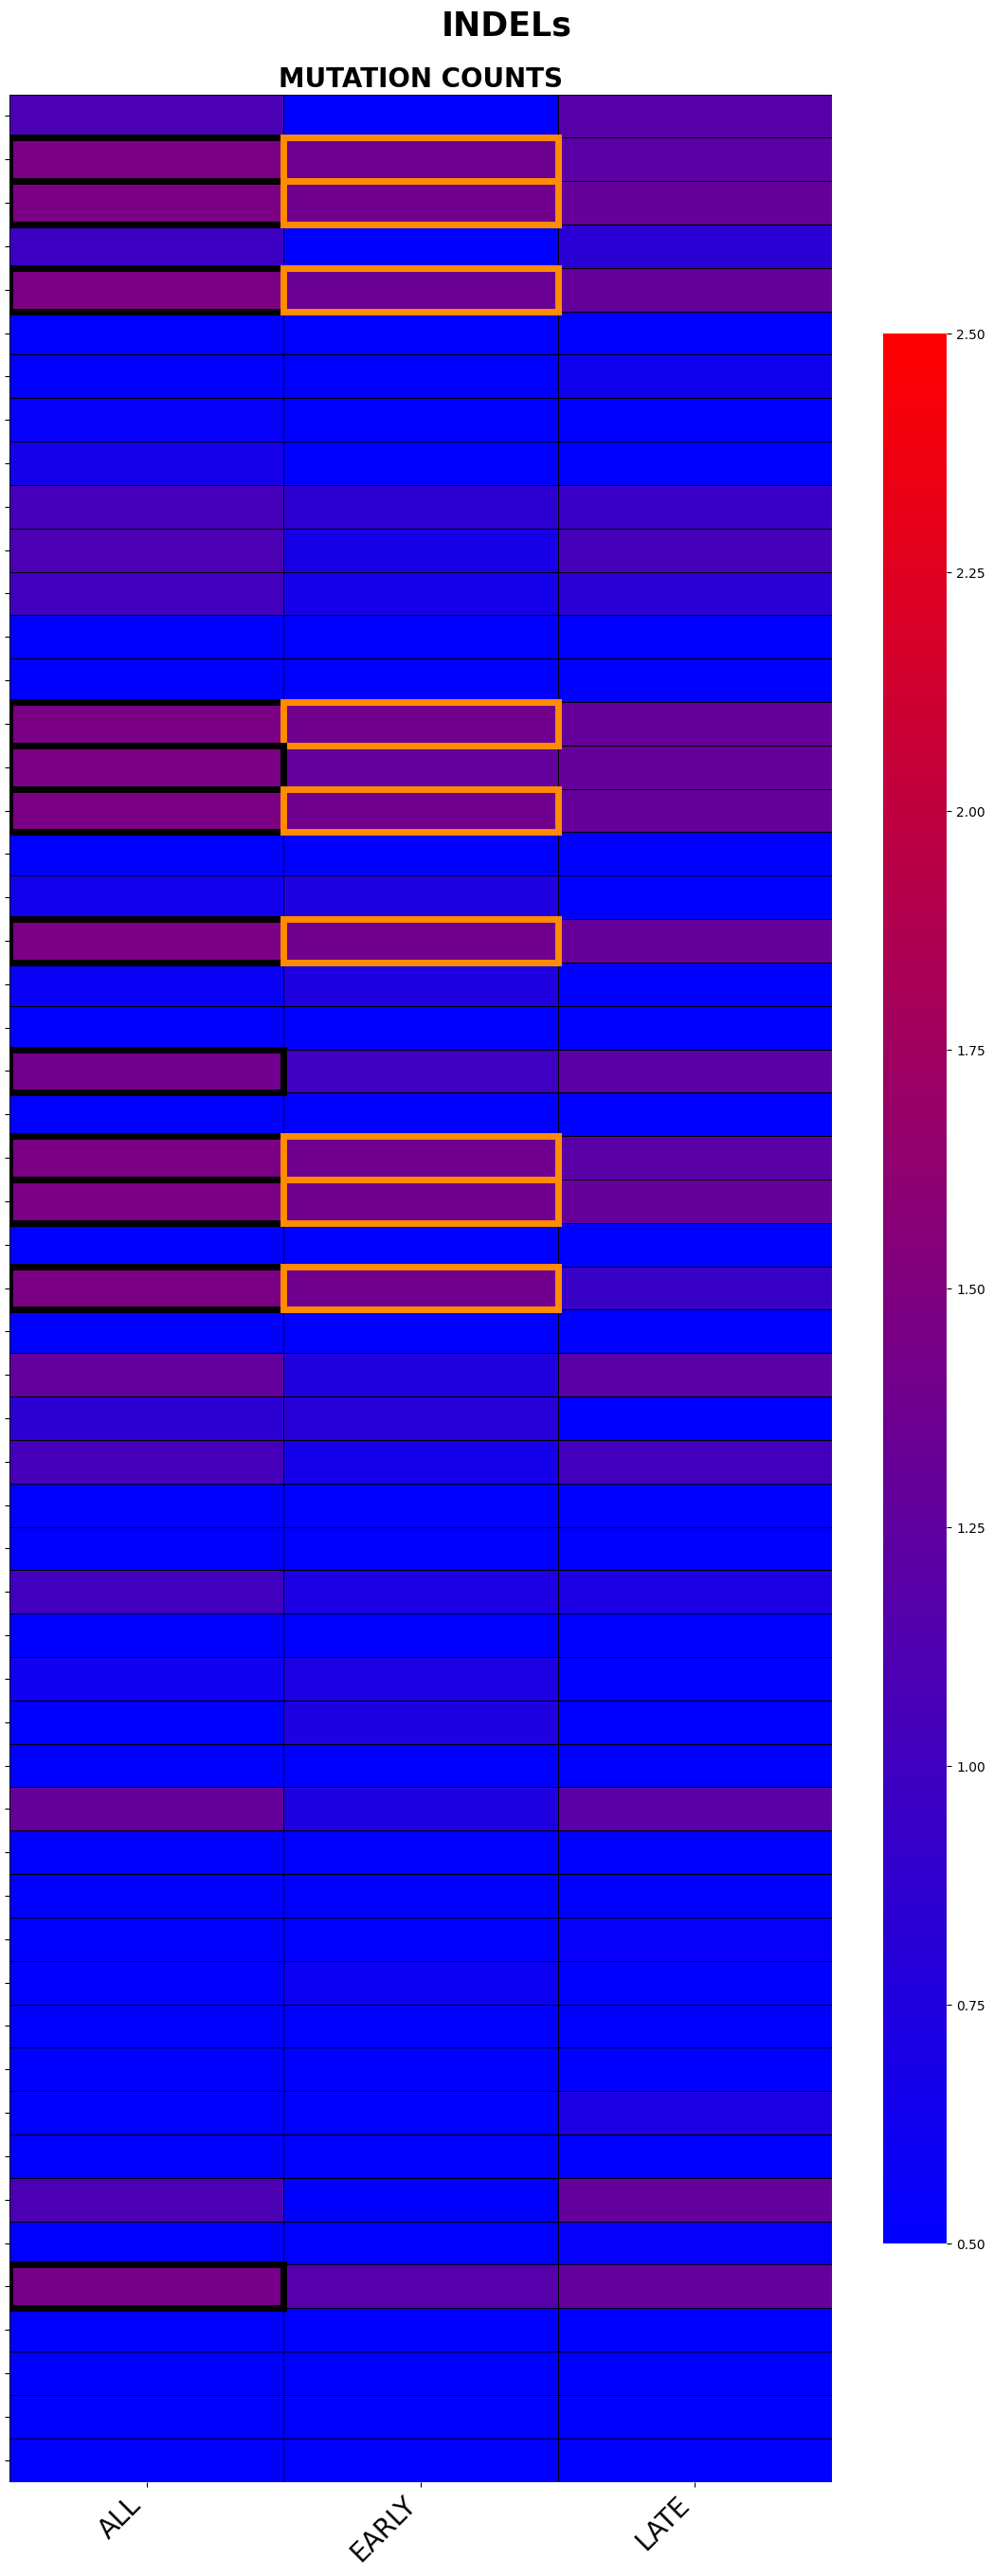

In [80]:
# summary of the results - heatmap
# Create DataFrame
df = pd.DataFrame({
    'COUNTS ALL': count_all,
    'COUNTS EARLY': count_early,
    'COUNTS LATE': count_late
}, index=sorted(set(exp_names_cut)))

# Apply -log10 transformation
df_transformed = -1*np.log10(df) #-1*log10(x)

# Filter the transformed dataframes to keep only significant rows - from the sbs analysis
filtered_df_trans = df_transformed.loc[['1,6-DNP (0.09 uM)', '1,8-DNP (0.125 uM)', '1,8-DNP (8 uM)',
       '3-NBA (0.025 uM)', '3-NBA (0.1 uM)', '4-ABP (300 uM) + S9',
       '5-Methylchrysene (1.6 uM) + S9', '6-Nitrochrysene (0.78 uM)',
       '6-Nitrochrysene (12.5 uM) + S9', '6-Nitrochrysene (50 uM)',
       '6-Nitrochrysene (50 uM) + S9', 'AAI (1.25 uM)', 'AAII (37.5 uM)',
       'AZD7762 (1.625 uM)', 'BPDE (0.125 uM)', 'BaP (0.39 uM) + S9',
       'BaP (2 uM) + S9', 'Benzidine (200 uM)', 'Carboplatin (5 uM)',
       'Cisplatin (12.5 uM)', 'Cisplatin (3.125 uM)',
       'Cyclophosphamide (18.75 uM) + S9', 'DBA (75 uM) + S9',
       'DBAC (5 uM) + S9', 'DBADE (0.0313 uM)', 'DBADE (0.109 uM)',
       'DBP (0.0039 uM)', 'DBP (0.0313 uM) + S9', 'DBPDE (0.000156 uM)',
       'DBPDE (0.000625 uM)', 'DES (0.938 mM)', 'DMH (11.6 mM) + S9',
       'DMS (0.078 mM)', 'ENU (400 uM)', 'Formaldehyde (120 uM)',
       'Furan (100 mM) + S9', 'Glycidamide (475 uM)', 'MMS (100 uM)',
       'MNU (350 uM)', 'MX (7 uM) + S9', 'Mechlorethamine (0.3 uM)',
       'Melphalan (1.5 uM)', 'Methyleugenol (1.25 mM)',
       'Mitomycin C (0.313 uM)', 'N-Nitrosopyrrolidine (50 mM)',
       'OTA (0.08 uM) + S9', 'Olaparib (0.625 uM)', 'PhIP (3 uM) + S9',
       'PhIP (4 uM) + S9', 'Potassium bromate (260 uM)',
       'Potassium bromate (875 uM)', 'Propylene oxide (10 mM)', 'SSR (1.25 J)',
       'Styrene oxide (75 uM)', 'Temozolomide (200 uM)']]

fig, ax = plt.subplots(figsize=(14, 30))
# Create custom blue-to-red colormap (no white in middle)
colors = ['blue', 'red']
custom_cmap = mcolors.LinearSegmentedColormap.from_list('custom_blue_red', colors)

vmin_val = 0.5
vmax_val = 2.5

ax=sns.heatmap(
    filtered_df_trans,
    cmap=custom_cmap,     # Blue to red color scale
    linewidths=0.5,
    cbar=True,
    annot=False,
    fmt=".2f",
    vmin=vmin_val,
    vmax=vmax_val,
    cbar_kws={'shrink': 0.8, 'aspect': 30}, linecolor='black'
)

edge_colors = {
    0: 'black',   # COUNTS ALL
    1: 'darkorange',    # COUNTS EARLY
    2: 'green'   # COUNTS LATE
}

for y in range(filtered_df_trans.shape[0]):
    for x in range(filtered_df_trans.shape[1]):
        if filtered_df_trans.iloc[y, x] > 1.3:
            color = edge_colors.get(x, 'yellow')
            rect = patches.Rectangle((x, y), 1, 1, fill=False, edgecolor=color, linewidth=5)
            ax.add_patch(rect)

ax.set_title("MUTATION COUNTS", fontsize=20, fontweight='bold')
ax.set_xticklabels(['ALL', 'EARLY', 'LATE'], rotation=45, ha='right', fontsize=20)
ax.set_yticklabels([])
# Overall title
fig.suptitle("INDELs", fontsize=25, fontweight='bold')
fig.subplots_adjust(top=0.95, wspace=0.05)

# Show the plot
plt.show()